In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from numpy import array
import math
from sklearn.metrics import mean_squared_error
import seaborn
from pylab import rcParams
from sklearn.ensemble import IsolationForest
import numpy as np
rcParams['figure.figsize'] = 20, 10

In [80]:
df = pd.read_csv('Twitter_volume_AMZN.csv')

In [81]:
df.head()

,timestamp,value
0,2015-02-26 21:42:53,57
1,2015-02-26 21:47:53,43
2,2015-02-26 21:52:53,55
3,2015-02-26 21:57:53,64
4,2015-02-26 22:02:53,93


In [84]:
df=df.reset_index()['value']

In [85]:
df.head()

0    57
1    43
2    55
3    64
4    93
Name: value, dtype: int64

In [86]:
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [87]:
data=[]
for i in range(len(df)):
  data.append(df[i][0])

In [88]:
print(data[:5])

[0.03407053197848177, 0.025702331141661684, 0.032875074716078895, 0.03825463239689181, 0.05558876270173341]


In [89]:
l=round(len(data)*0.95)
print(l)

15039


In [90]:
train=data[:l]
test=data[l:]

In [91]:
def generateData(x,t,s):
  xt=[]
  yt=[]
  for i in range(t,(len(x)-s)):
    xt.append(x[i-t:i])
    yt.append(x[i:i+s])
  return np.array(xt),np.array(yt)

**Methods we are going to use for Anomoly Detection**


---
1) Using Z score

Formula for Z score = (Observation — Mean)/Standard Deviation

z = (X — μ) / σ


---

2) 
InterQuantile Range

75%- 25% values in a dataset
Steps
1. Arrange the data in increasing order
2. Calculate first(q1) and third quartile(q3)
3. Find interquartile range (q3-q1)
4.Find lower bound q1*1.5
5.Find upper bound q3*1.5

Anything that lies outside of lower and upper bound is an outlier



---

3)  Standard Deviation:
In statistics, If a data distribution is approximately normal then about 68% of the data values lie within one standard deviation of the mean and about 95% are within two standard deviations, and about 99.7% lie within three standard deviationsTherefore, if you have any data point that is more than 3 times the standard deviation, then those points are very likely to be anomalous or outliers.


***For Timestep=30 and Predicted Sequence=5***

In [92]:
timestep = 30
sequence = 5
xtrain_1,ytrain_1= generateData(train,timestep,sequence)
xtest_1,ytest_1 = generateData(test,timestep,sequence)

In [93]:
print(xtrain_1.shape)
print(ytrain_1.shape)
print(xtest_1.shape)
print(ytest_1.shape)

(15004, 30)
(15004, 5)
(757, 30)
(757, 5)


In [94]:
n_features = 1

xtrain_1 = xtrain_1.reshape((xtrain_1.shape[0], xtrain_1.shape[1], n_features))
ytrain_1 = ytrain_1.reshape((ytrain_1.shape[0], ytrain_1.shape[1]))

xtest_1 = xtest_1.reshape((xtest_1.shape[0], xtest_1.shape[1], n_features))
ytest_1 = ytest_1.reshape((ytest_1.shape[0], ytest_1.shape[1]))

In [95]:
print(xtrain_1.shape)
print(ytrain_1.shape)
print(xtest_1.shape)
print(ytest_1.shape)

(15004, 30, 1)
(15004, 5)
(757, 30, 1)
(757, 5)


In [96]:
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(timestep, n_features)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(sequence))
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

In [100]:
history = model.fit(xtrain_1,ytrain_1,validation_data=(xtest_1,ytest_1),epochs=100,batch_size=400,verbose=1)

Epoch 1/100
38/38 [==============================] - 7s 176ms/step - loss: 2.5057e-04 - accuracy: 0.2037 - val_loss: 9.8175e-05 - val_accuracy: 0.1915
Epoch 2/100
38/38 [==============================] - 7s 175ms/step - loss: 2.4553e-04 - accuracy: 0.2096 - val_loss: 9.7342e-05 - val_accuracy: 0.2074
Epoch 3/100
38/38 [==============================] - 7s 174ms/step - loss: 2.4552e-04 - accuracy: 0.2106 - val_loss: 9.6819e-05 - val_accuracy: 0.1942
Epoch 4/100
38/38 [==============================] - 7s 175ms/step - loss: 2.4469e-04 - accuracy: 0.2138 - val_loss: 9.6770e-05 - val_accuracy: 0.2166
Epoch 5/100
38/38 [==============================] - 7s 175ms/step - loss: 2.4482e-04 - accuracy: 0.2089 - val_loss: 9.6554e-05 - val_accuracy: 0.2061
Epoch 6/100
38/38 [==============================] - 7s 175ms/step - loss: 2.4545e-04 - accuracy: 0.2117 - val_loss: 9.6826e-05 - val_accuracy: 0.2299
Epoch 7/100
38/38 [==============================] - 7s 175ms/step - loss: 2.4485e-04 - accura

Text(0.5, 0, 'epoch')

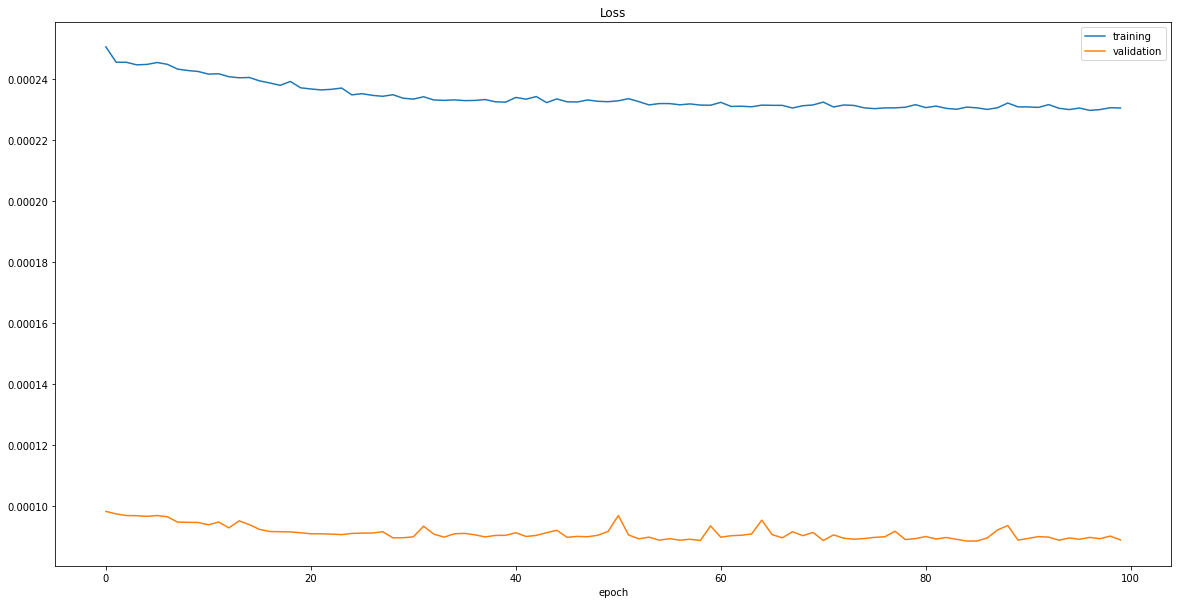

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

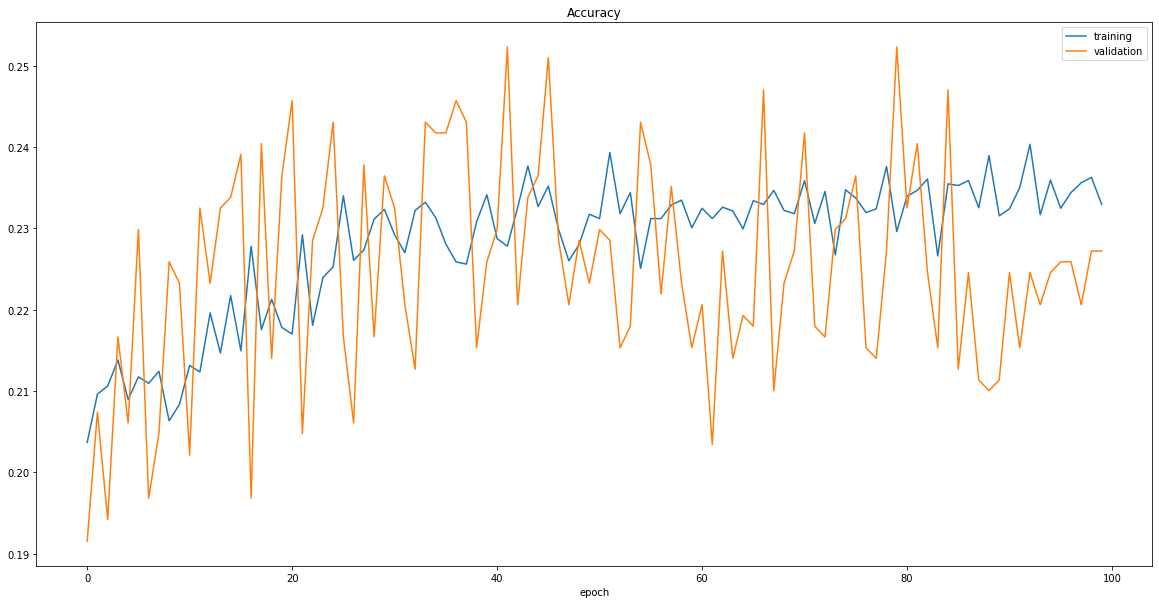

In [102]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [103]:
yhat = model.predict(xtest_1, verbose=0)

In [104]:
yhat = yhat.mean(axis=1)
ytest = ytest_1.mean(axis=1)

OutLiers Using ZScore

In [105]:
def calc_Outliers_zscore(data):
  outliers=[]
  idx=[]
  threshold=3
  mean = np.mean(data)
  std =np.std(data)
  for i in range(len(data)):
    z_score= (data[i] - mean)/std 
    if np.abs(z_score) > threshold:
      outliers.append(data[i])
      idx.append(i)
  return outliers,idx

In [106]:
yhat_outlier,yhat_index = calc_Outliers_zscore(yhat)
ytest_outlier,ytest_index = calc_Outliers_zscore(ytest)

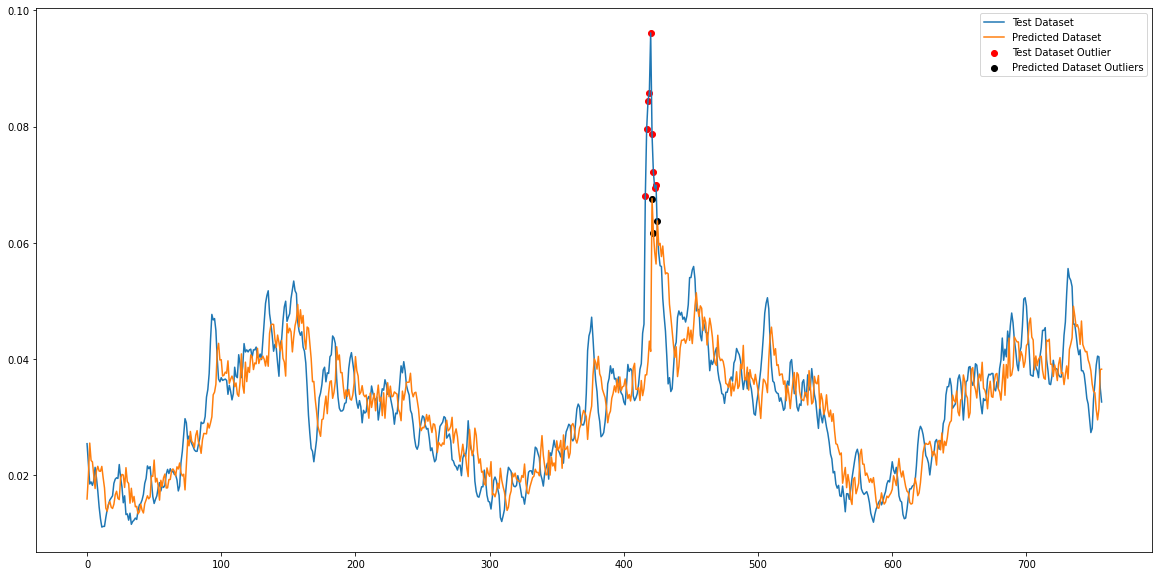

In [107]:
plt.plot(ytest,label='Test Dataset')
plt.scatter(ytest_index, ytest_outlier, c ="red",label='Test Dataset Outlier')

plt.plot(yhat,label='Predicted Dataset')
plt.scatter(yhat_index, yhat_outlier, c ="black",label='Predicted Dataset Outliers') 

plt.legend() 
plt.show() 

Outliers using InterQuantile Range

In [108]:
def interQauntileOutlier(x):
  a=sorted(x)
  quantile1, quantile3= np.percentile(a,[25,75])
  outliers=[]
  idx=[]
  for i in range(len(x)):
    if (x[i]<quantile1 or x[i]>quantile3):
      outliers.append(x[i])
      idx.append(i)
  return outliers,idx

In [109]:
yhat_outlier,yhat_index = interQauntileOutlier(yhat)
ytest_outlier,ytest_index = interQauntileOutlier(ytest)

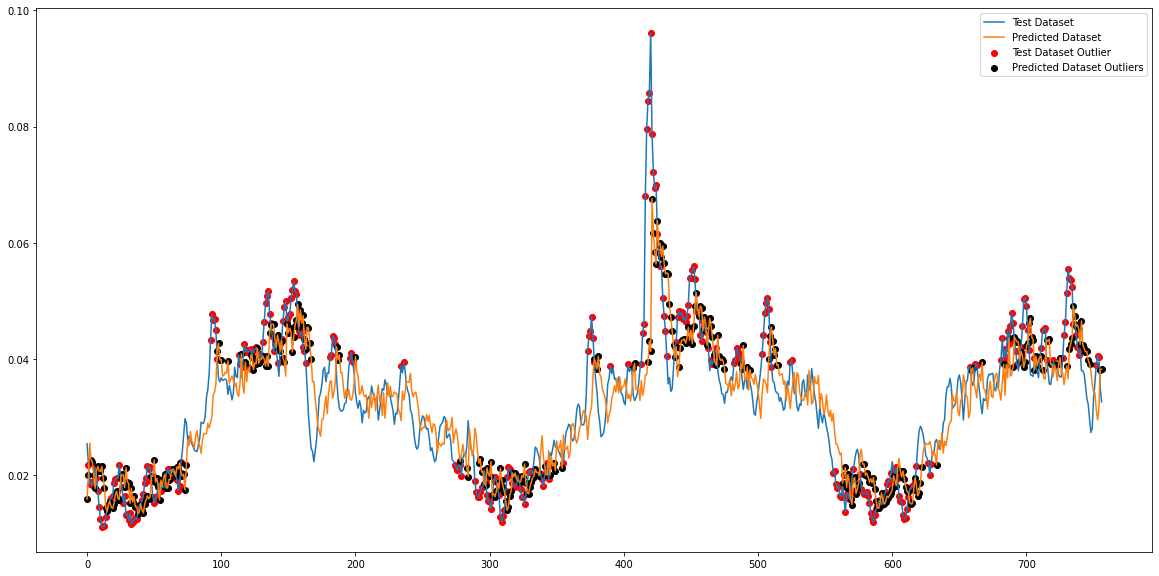

In [110]:
plt.plot(ytest,label='Test Dataset')
plt.scatter(ytest_index, ytest_outlier, c ="red",label='Test Dataset Outlier')

plt.plot(yhat,label='Predicted Dataset')
plt.scatter(yhat_index, yhat_outlier, c ="black",label='Predicted Dataset Outliers') 

plt.legend() 
plt.show() 

Outlier Detection using Standard Deviation to set Upper and Lower Bound

In [111]:
def outliesrDetect(x):
  mean=np.mean(x)
  std=np.std(x)
  anomaly_cut_off= std*2

  lower_limit = mean - anomaly_cut_off 
  upper_limit = mean + anomaly_cut_off

  outliers=[]
  idx=[]
  for i in range(len(x)):
    if (x[i] > upper_limit or x[i] < lower_limit):
      outliers.append(x[i])
      idx.append(i)
  return outliers,idx


In [112]:
yhat_outlier,yhat_index = outliesrDetect(yhat)
ytest_outlier,ytest_index = outliesrDetect(ytest)

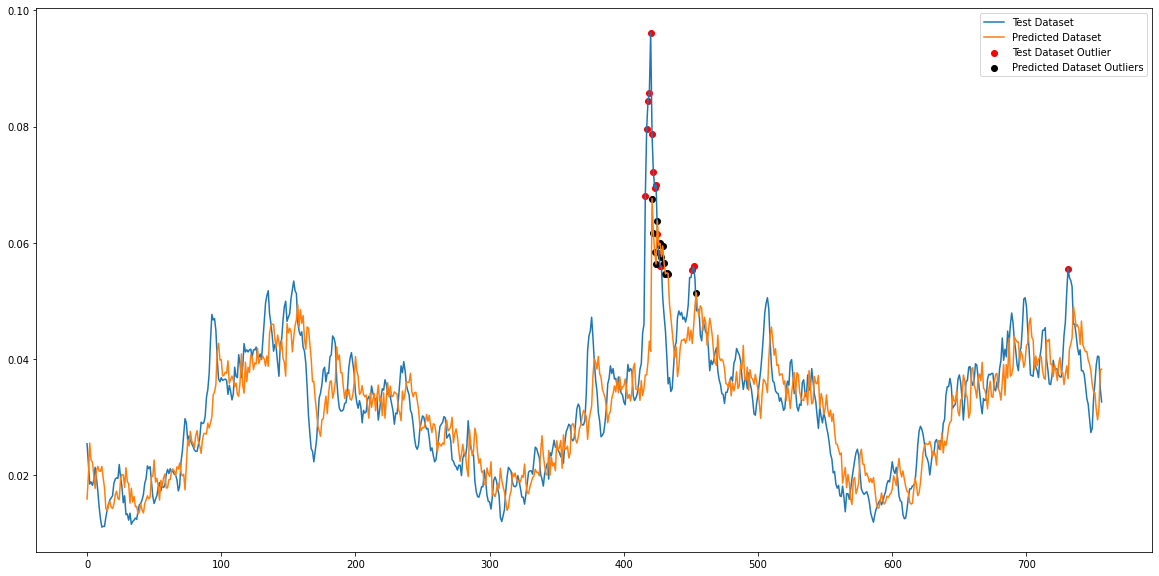

In [113]:
plt.plot(ytest,label='Test Dataset')
plt.scatter(ytest_index, ytest_outlier, c ="red",label='Test Dataset Outlier')

plt.plot(yhat,label='Predicted Dataset')
plt.scatter(yhat_index, yhat_outlier, c ="black",label='Predicted Dataset Outliers') 

plt.legend() 
plt.show() 

***For Timestep=50 and Predicted Sequence=7***

In [ ]:
timestep = 40
sequence = 7

xtrain_2,ytrain_2 = generateData(train,timestep,sequence)
xtest_2,ytest_2 = generateData(test,timestep,sequence)

In [160]:
n_features = 1

xtrain_2 = xtrain_2.reshape((xtrain_2.shape[0], xtrain_2.shape[1], n_features))
ytrain_2 = ytrain_2.reshape((ytrain_2.shape[0], ytrain_2.shape[1]))

xtest_2 = xtest_2.reshape((xtest_2.shape[0], xtest_2.shape[1], n_features))
ytest_2 = ytest_2.reshape((ytest_2.shape[0], ytest_2.shape[1]))

In [161]:
model2=Sequential()
model2.add(LSTM(50,return_sequences=True, input_shape=(timestep, n_features)))
model2.add(LSTM(50,return_sequences=True))
model2.add(LSTM(50))
model2.add(Dense(sequence))
model2.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

In [163]:
history1 = model2.fit(xtrain_2,ytrain_2,validation_data=(xtest_2,ytest_2),epochs=20,batch_size=500,verbose=1)

Epoch 1/20
30/30 [==============================] - 9s 306ms/step - loss: 4.1479e-04 - accuracy: 0.1525 - val_loss: 1.4823e-04 - val_accuracy: 0.1758
Epoch 2/20
30/30 [==============================] - 8s 273ms/step - loss: 2.7848e-04 - accuracy: 0.1436 - val_loss: 1.1637e-04 - val_accuracy: 0.1342
Epoch 3/20
30/30 [==============================] - 8s 277ms/step - loss: 2.6419e-04 - accuracy: 0.1477 - val_loss: 1.1256e-04 - val_accuracy: 0.1423
Epoch 4/20
30/30 [==============================] - 8s 275ms/step - loss: 2.6093e-04 - accuracy: 0.1543 - val_loss: 1.1083e-04 - val_accuracy: 0.1423
Epoch 5/20
30/30 [==============================] - 8s 275ms/step - loss: 2.5978e-04 - accuracy: 0.1531 - val_loss: 1.1206e-04 - val_accuracy: 0.1785
Epoch 6/20
30/30 [==============================] - 8s 274ms/step - loss: 2.5888e-04 - accuracy: 0.1533 - val_loss: 1.1031e-04 - val_accuracy: 0.1248
Epoch 7/20
30/30 [==============================] - 8s 275ms/step - loss: 2.5950e-04 - accuracy: 0.1

Text(0.5, 0, 'epoch')

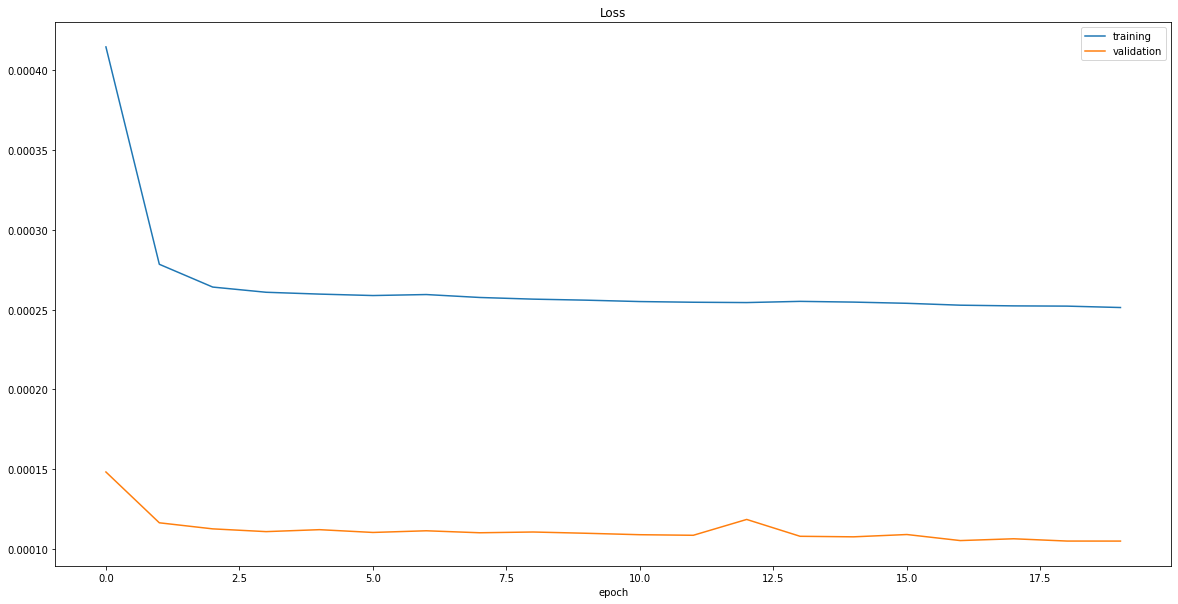

In [164]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

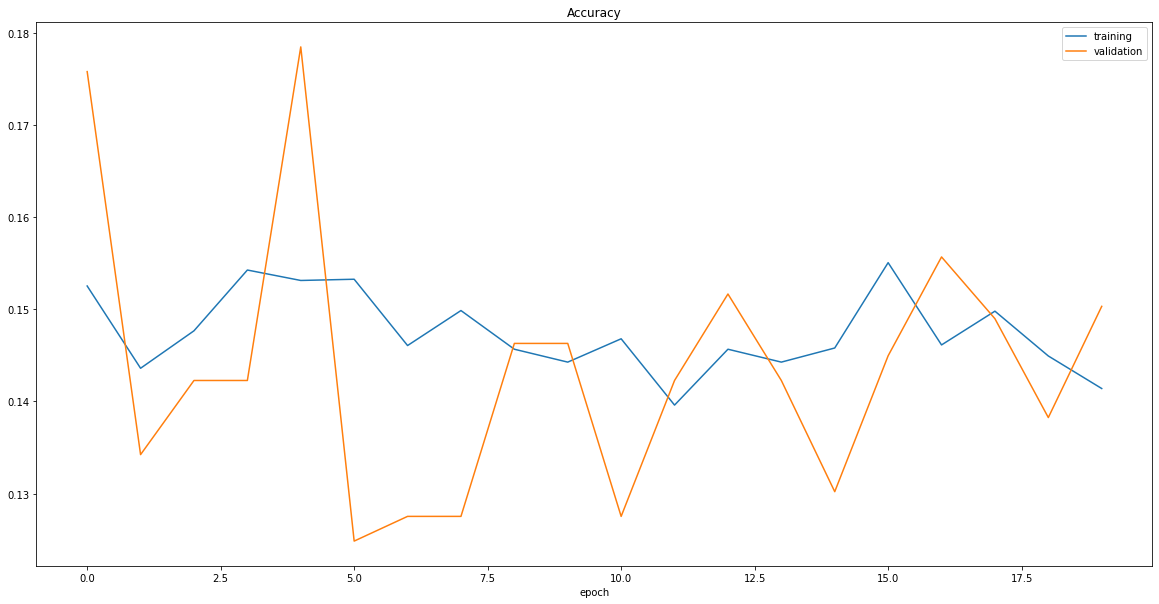

In [165]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [166]:
yhat = model2.predict(xtest_2, verbose=0)

In [167]:
yhat = yhat.mean(axis=1)
ytest = ytest_2.mean(axis=1)

Outliers Using Zscore

In [168]:
yhat_outlier,yhat_index = calc_Outliers_zscore(yhat)
ytest_outlier,ytest_index = calc_Outliers_zscore(ytest)

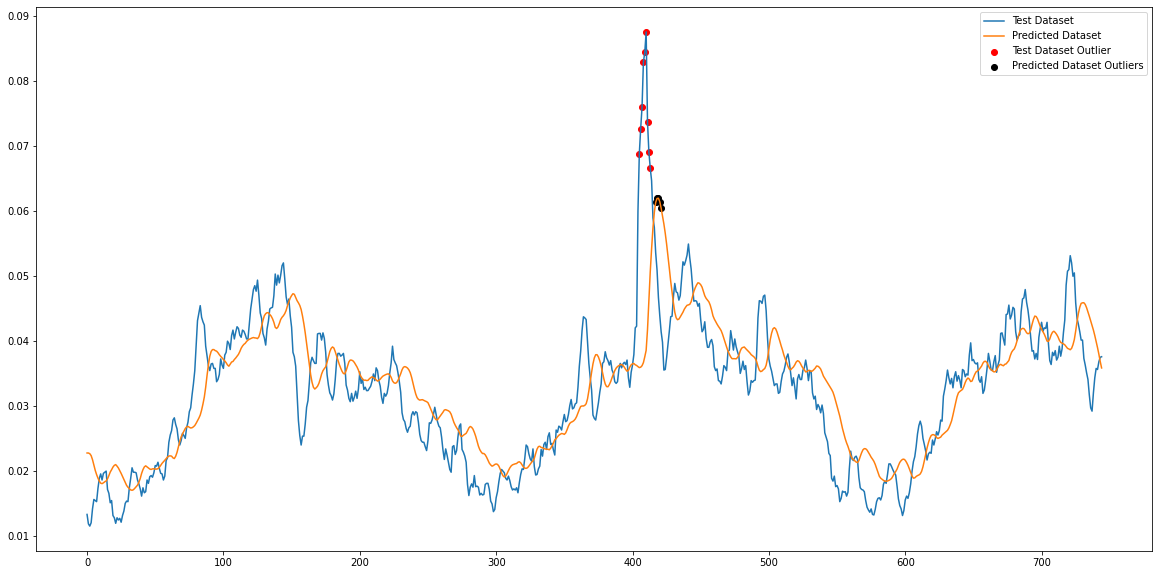

In [169]:
plt.plot(ytest,label='Test Dataset')
plt.scatter(ytest_index, ytest_outlier, c ="red",label='Test Dataset Outlier')

plt.plot(yhat,label='Predicted Dataset')
plt.scatter(yhat_index, yhat_outlier, c ="black",label='Predicted Dataset Outliers') 

plt.legend() 
plt.show() 

Outliers using Interquantile Range

In [170]:
yhat_outlier,yhat_index = interQauntileOutlier(yhat)
ytest_outlier,ytest_index = interQauntileOutlier(ytest)

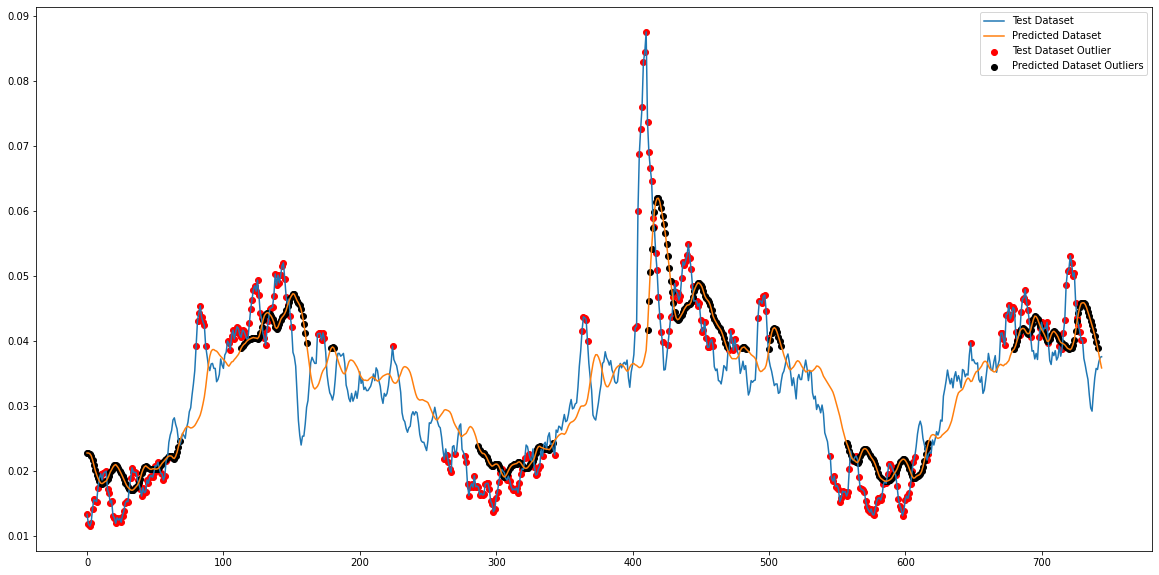

In [171]:
plt.plot(ytest,label='Test Dataset')
plt.scatter(ytest_index, ytest_outlier, c ="red",label='Test Dataset Outlier')

plt.plot(yhat,label='Predicted Dataset')
plt.scatter(yhat_index, yhat_outlier, c ="black",label='Predicted Dataset Outliers') 

plt.legend() 
plt.show() 

Outlier Detection using Standard Deviation to set Upper and Lower Bound

In [172]:
yhat_outlier,yhat_index = outliesrDetect(yhat)
ytest_outlier,ytest_index = outliesrDetect(ytest)

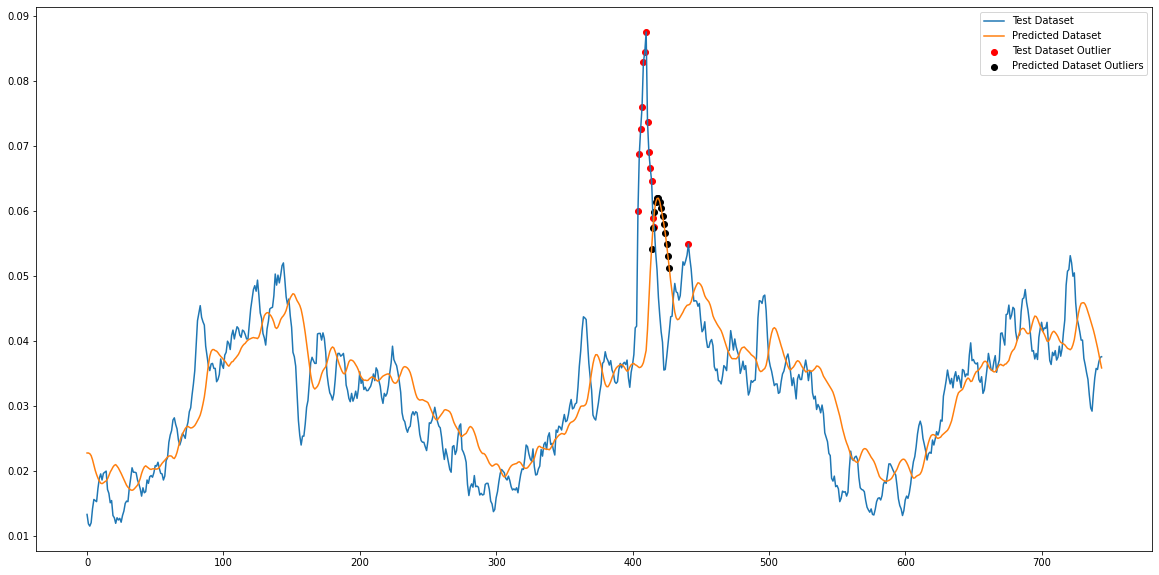

In [173]:
plt.plot(ytest,label='Test Dataset')
plt.scatter(ytest_index, ytest_outlier, c ="red",label='Test Dataset Outlier')

plt.plot(yhat,label='Predicted Dataset')
plt.scatter(yhat_index, yhat_outlier, c ="black",label='Predicted Dataset Outliers') 

plt.legend() 
plt.show() 

***For Timestep=100 and Predicted Sequence=8***

In [133]:
timestep = 100
sequence = 8

xtrain_3,ytrain_3 = generateData(train,timestep,sequence)
xtest_3,ytest_3 = generateData(test,timestep,sequence)

In [134]:
n_features = 1

xtrain_3 = xtrain_3.reshape((xtrain_3.shape[0], xtrain_3.shape[1], n_features))
ytrain_3 = ytrain_3.reshape((ytrain_3.shape[0], ytrain_3.shape[1]))

xtest_3 = xtest_3.reshape((xtest_3.shape[0], xtest_3.shape[1], n_features))
ytest_3 = ytest_3.reshape((ytest_3.shape[0], ytest_3.shape[1]))

In [135]:
model3=Sequential()
model3.add(LSTM(50,return_sequences=True, input_shape=(timestep, n_features)))
model3.add(LSTM(50,return_sequences=True))
model3.add(LSTM(50))
model3.add(Dense(sequence))
model3.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

In [136]:
history2 = model3.fit(xtrain_3,ytrain_3,validation_data=(xtest_3,ytest_3),epochs=25,batch_size=500,verbose=1)

Epoch 1/25
30/30 [==============================] - 21s 706ms/step - loss: 4.1435e-04 - accuracy: 0.1219 - val_loss: 1.5209e-04 - val_accuracy: 0.1257
Epoch 2/25
30/30 [==============================] - 20s 666ms/step - loss: 2.8204e-04 - accuracy: 0.1317 - val_loss: 1.1952e-04 - val_accuracy: 0.1535
Epoch 3/25
30/30 [==============================] - 20s 665ms/step - loss: 2.6308e-04 - accuracy: 0.1257 - val_loss: 1.1758e-04 - val_accuracy: 0.1272
Epoch 4/25
30/30 [==============================] - 20s 668ms/step - loss: 2.6287e-04 - accuracy: 0.1291 - val_loss: 1.1567e-04 - val_accuracy: 0.1447
Epoch 5/25
30/30 [==============================] - 20s 667ms/step - loss: 2.6015e-04 - accuracy: 0.1352 - val_loss: 1.1548e-04 - val_accuracy: 0.1272
Epoch 6/25
30/30 [==============================] - 20s 664ms/step - loss: 2.5911e-04 - accuracy: 0.1315 - val_loss: 1.1685e-04 - val_accuracy: 0.1301
Epoch 7/25
30/30 [==============================] - 20s 667ms/step - loss: 2.5861e-04 - accura

Text(0.5, 0, 'epoch')

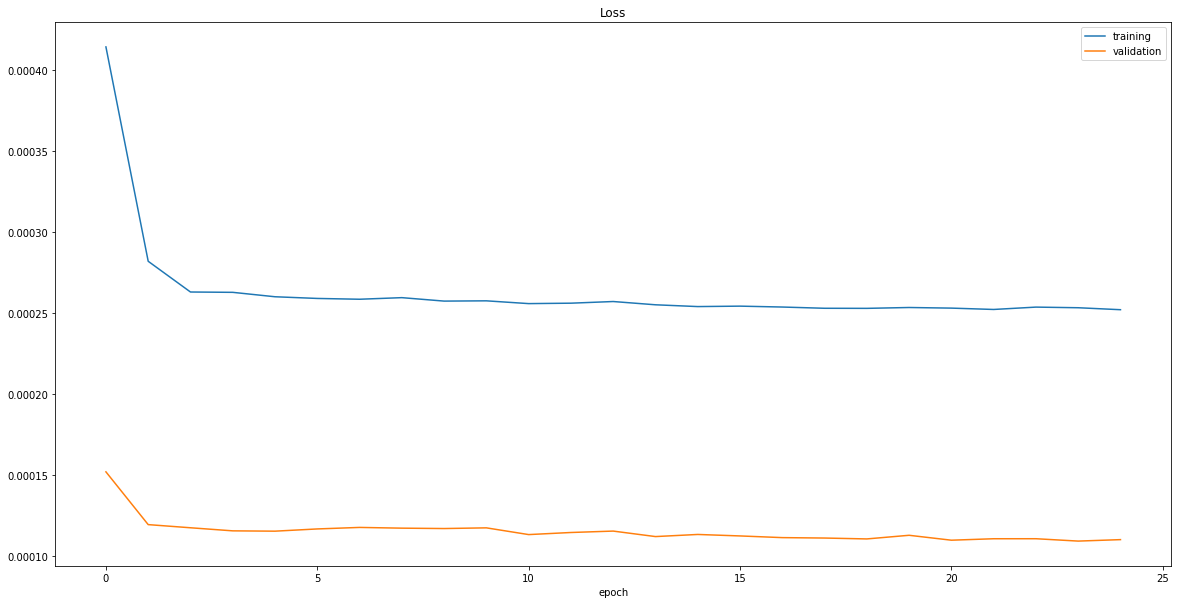

In [137]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

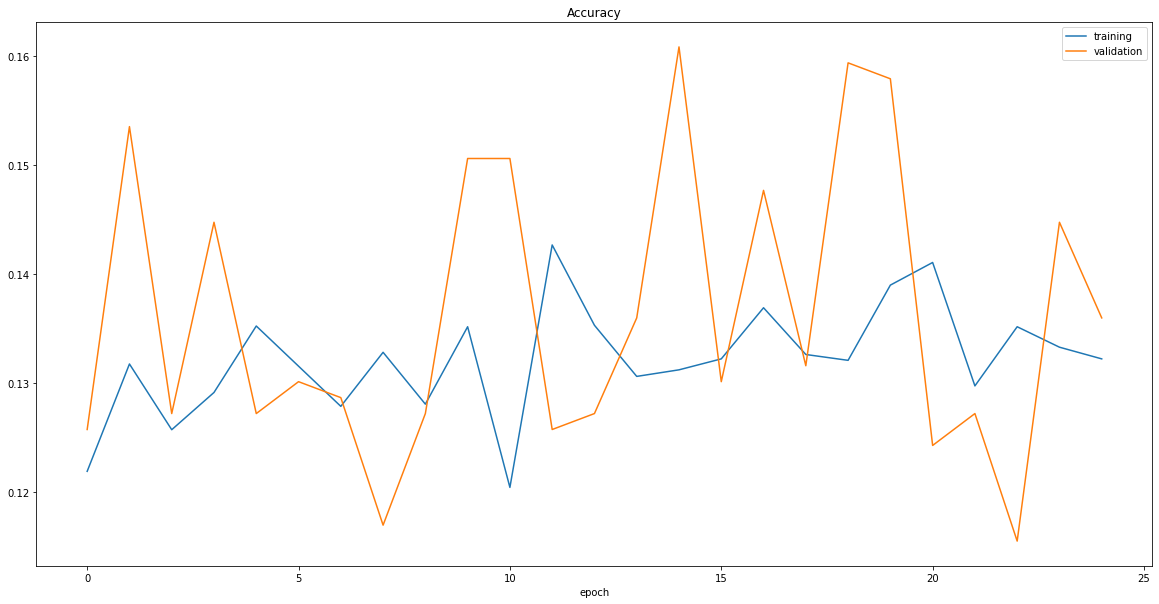

In [138]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [139]:
yhat = model3.predict(xtest_2, verbose=0)

In [140]:
yhat = yhat.mean(axis=1)
ytest = ytest_3.mean(axis=1)

Outliers Using Zscore

In [141]:
yhat_outlier,yhat_index = calc_Outliers_zscore(yhat)
ytest_outlier,ytest_index = calc_Outliers_zscore(ytest)

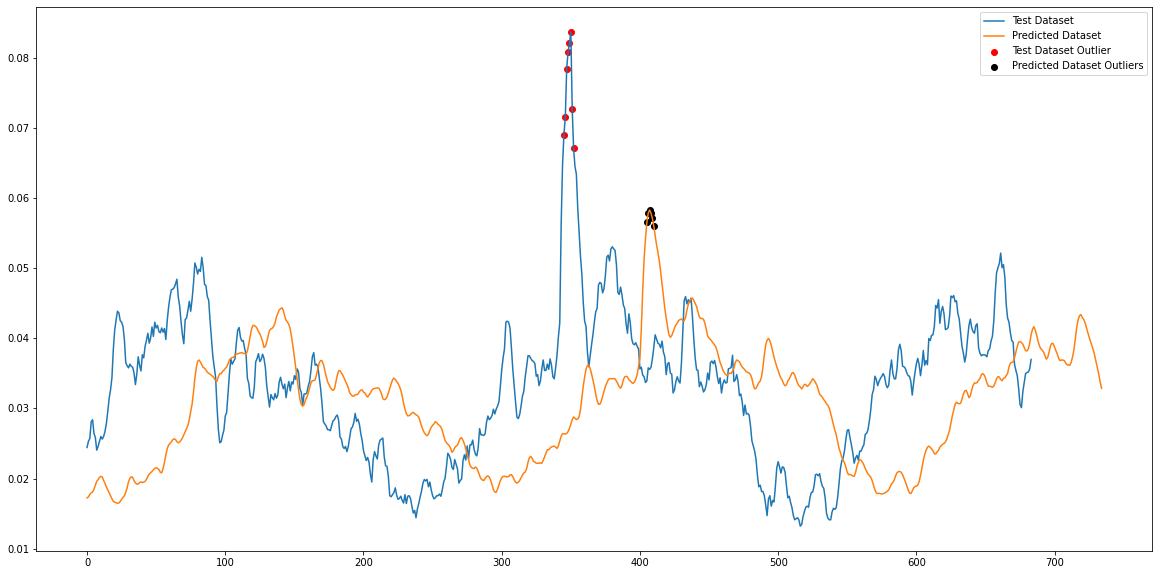

In [142]:
plt.plot(ytest,label='Test Dataset')
plt.scatter(ytest_index, ytest_outlier, c ="red",label='Test Dataset Outlier')

plt.plot(yhat,label='Predicted Dataset')
plt.scatter(yhat_index, yhat_outlier, c ="black",label='Predicted Dataset Outliers') 

plt.legend() 
plt.show()

Outliers Using Inter Quantile Range

In [143]:
yhat_outlier,yhat_index = interQauntileOutlier(yhat)
ytest_outlier,ytest_index = interQauntileOutlier(ytest)

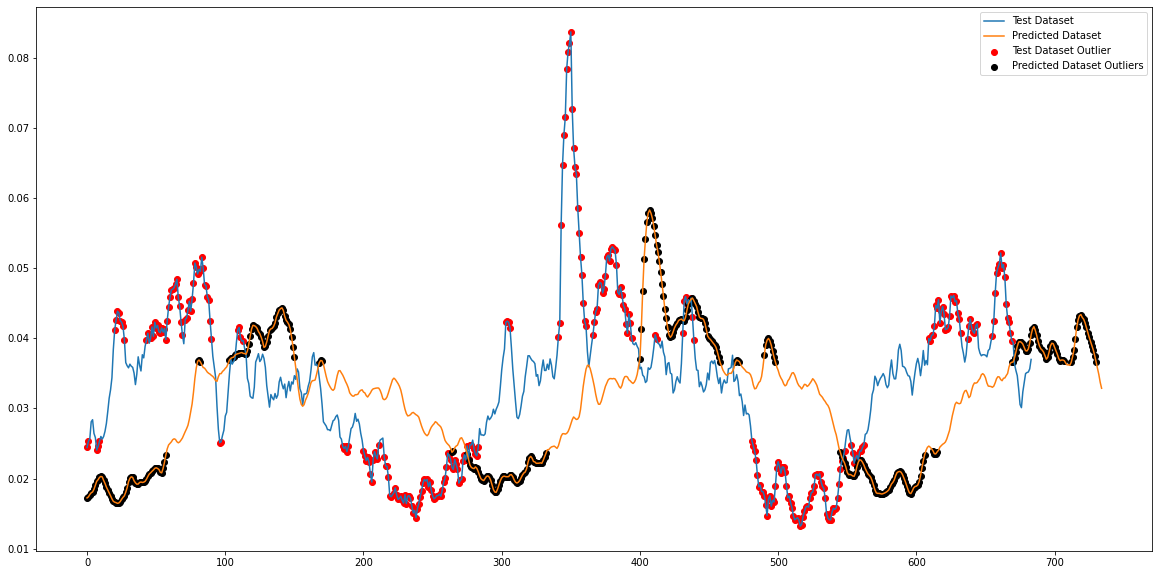

In [144]:
plt.plot(ytest,label='Test Dataset')
plt.scatter(ytest_index, ytest_outlier, c ="red",label='Test Dataset Outlier')

plt.plot(yhat,label='Predicted Dataset')
plt.scatter(yhat_index, yhat_outlier, c ="black",label='Predicted Dataset Outliers') 

plt.legend() 
plt.show()

Outlier Detection using Standard Deviation to set Upper and Lower Bound

In [145]:
yhat_outlier,yhat_index = outliesrDetect(yhat)
ytest_outlier,ytest_index = outliesrDetect(ytest)

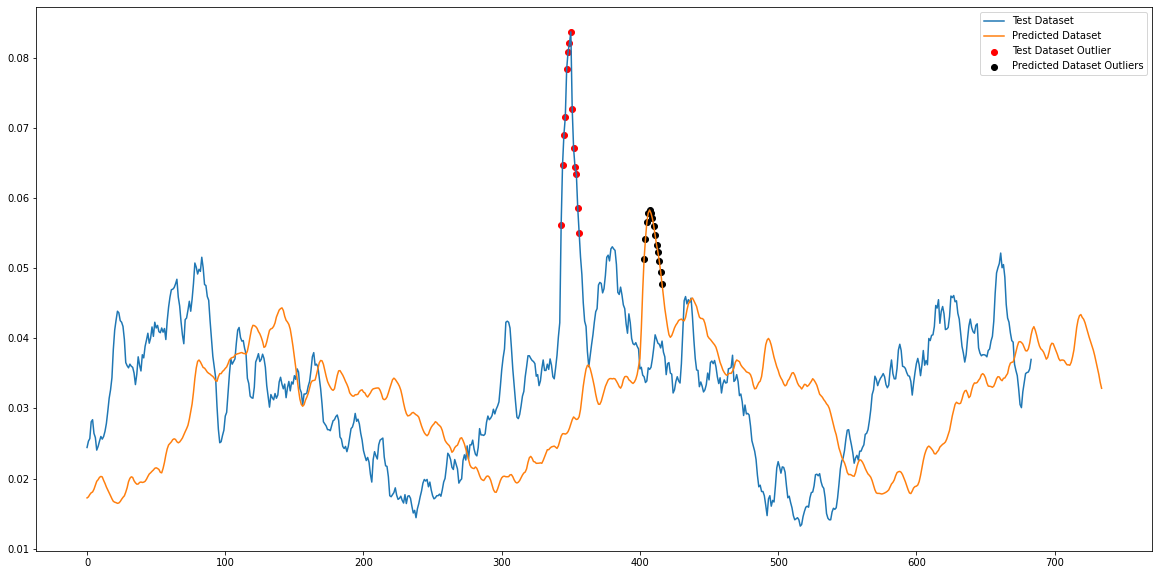

In [146]:
plt.plot(ytest,label='Test Dataset')
plt.scatter(ytest_index, ytest_outlier, c ="red",label='Test Dataset Outlier')

plt.plot(yhat,label='Predicted Dataset')
plt.scatter(yhat_index, yhat_outlier, c ="black",label='Predicted Dataset Outliers') 

plt.legend() 
plt.show()

**********************************************************

Observations: Its clearly visible from the graph that we get more ouliers using Inter-Quantile range and thats because we are setting two boundraies one is upper limit and the other is lower limit.
Using the zscore we are getting less outliers that can be changed by adjusting the threshold, currently we have set the threshold 3, but looking at the this result it seems us the give the right accuracies. The other method called finding outliers using Standard Deviation seems to give us similar result.

